In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16,preprocess_input
import imageio
import cv2 
import glob
import numpy as np
from PIL import Image
from torchvision import transforms

In [2]:
dataset_dir = "./Data"

images = []
labels = []


for class_label in os.listdir(dataset_dir):
    print(class_label)
    class_dir = os.path.join(dataset_dir, class_label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                print(image_path)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
                image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(class_label)

                # Load your 20x20 image

                # Resize the image to 224x224
                


# Now you can use this resized image as input to the VGG16 model for feature extraction.


dsimages = np.array(images)
dslabels = np.array(labels)

Without_Ships
./Data\Without_Ships\0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png
./Data\Without_Ships\0__20150718_184300_090b__-122.40477488428849_37.8071040053892.png
./Data\Without_Ships\0__20150830_000650_0b07__-122.40480193174041_37.757000251300894.png
./Data\Without_Ships\0__20150830_000650_0b07__-122.42961510889906_37.781052845407665.png
./Data\Without_Ships\0__20150830_000652_1_0b07__-122.27654713066907_37.77410158935401.png
./Data\Without_Ships\0__20160704_204236_0c41__-122.19041500809534_37.8972978006019.png
./Data\Without_Ships\0__20160710_182139_0c78__-122.30593748745294_37.87681028471107.png
./Data\Without_Ships\0__20160710_182140_0c78__-122.28861764306099_37.80132238942605.png
./Data\Without_Ships\0__20160710_182140_0c78__-122.36167510647154_37.72651739424844.png
./Data\Without_Ships\0__20160905_193457_1_0c37__-122.43294059528056_37.72477265075141.png
./Data\Without_Ships\0__20160905_193457_1_0c37__-122.46023886886336_37.77216594085852.png
./Data\With

In [3]:
print(dslabels.shape)
print(dsimages.shape)

(3992,)
(3992, 224, 224, 3)


In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(dsimages,dslabels,test_size=0.2,random_state=42)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3193, 224, 224, 3)
(3193,)
(799, 224, 224, 3)
(799,)


In [6]:
X_train = X_train/255
X_test = X_test/255

In [52]:
X_train.shape

(3193, 224, 224, 3)

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
le.fit(y_test)
y_test_encoded = le.transform(y_test)

In [8]:
vgg_Model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in vgg_Model.layers:
    layer.trainable = False

vgg_Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
featureExtractorTrain = vgg_Model.predict(X_train)

100/100 [==============================] - 322s 3s/step


In [50]:
featureExtractorTrain.shape

(3193, 7, 7, 512)

In [10]:
featureExtractorTest = vgg_Model.predict(X_test)

25/25 [==============================] - 86s 3s/step


In [11]:
featuresTrain = featureExtractorTrain.reshape(featureExtractorTrain.shape[0],-1)
featuresTest = featureExtractorTest.reshape(featureExtractorTest.shape[0],-1)

In [51]:
featuresTrain.shape

(3193, 25088)

## RANDOM FOREST CLASSIFIER

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50,random_state=42)

In [13]:
rf.fit(featuresTrain,y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [14]:
predictionRF = rf.predict(featuresTest)

In [17]:
featuresTest.shape

(799, 25088)

In [19]:
from sklearn.metrics import classification_report
import seaborn as sns


print(classification_report(y_test,predictionRF))
cm = classification_report(y_test,predictionRF)


               precision    recall  f1-score   support

   With_Ships       0.97      0.93      0.95       395
Without_Ships       0.94      0.97      0.95       404

     accuracy                           0.95       799
    macro avg       0.95      0.95      0.95       799
 weighted avg       0.95      0.95      0.95       799



In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming cm is the classification report you mentioned
cm = classification_report(y_test, predictionRF)

# Extracting the true labels and the predicted labels
y_true = y_test  # Ensure y_test is in the appropriate format
y_pred = predictionRF  # Ensure predictionRF is in the appropriate format

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix as a heatmap with a color bar
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True, annot_kws={"size": 14},
            xticklabels=['Without_Ships', 'With_Ships'], yticklabels=['Without_Ships', 'With_Ships'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix for Random Forest', fontsize=16)
plt.show()



InvalidParameterError: The 'y_pred' parameter of classification_report must be an array-like or a sparse matrix. Got 'Without_Ships' instead.

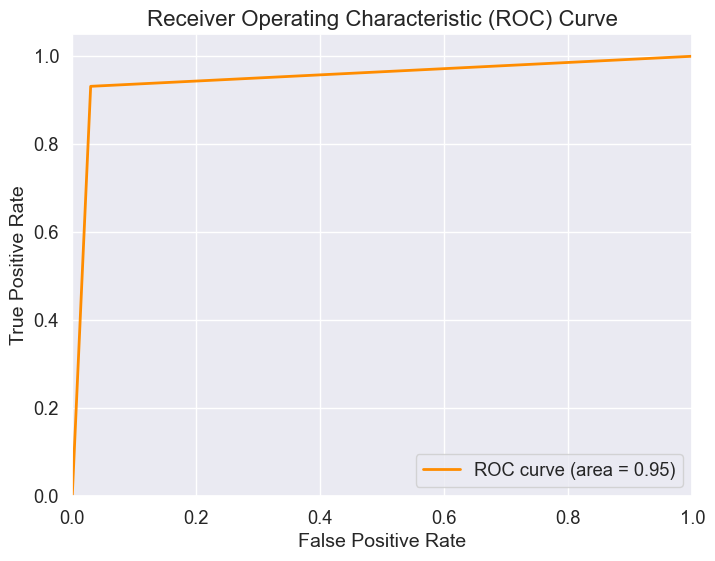

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_true_numeric = [1 if label == 'With_Ships' else 0 for label in y_true]
y_pred_numeric = [1 if label == 'With_Ships' else 0 for label in y_pred]

# Assuming the data is stored in y_true and y_pred variables
# Convert the string labels to numerical format as shown in the previous example

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true_numeric, y_pred_numeric)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


In [35]:
from sklearn.metrics import f1_score,recall_score,precision_score

y_true_numeric = [1 if label == 'With_Ships' else 0 for label in y_true]
y_pred_numeric = [1 if label == 'With_Ships' else 0 for label in y_pred]

print("Recall Score: ",recall_score(y_true_numeric,y_pred_numeric))
print("F1-Score: ",f1_score(y_true_numeric,y_pred_numeric))
print("Precision Score: ",precision_score(y_true_numeric,y_pred_numeric))

Recall Score:  0.9316455696202531
F1-Score:  0.9496774193548386
Precision Score:  0.968421052631579


In [16]:
from sklearn import metrics
print("Accuracy = ",metrics.accuracy_score(y_test,predictionRF))

Accuracy =  0.951188986232791


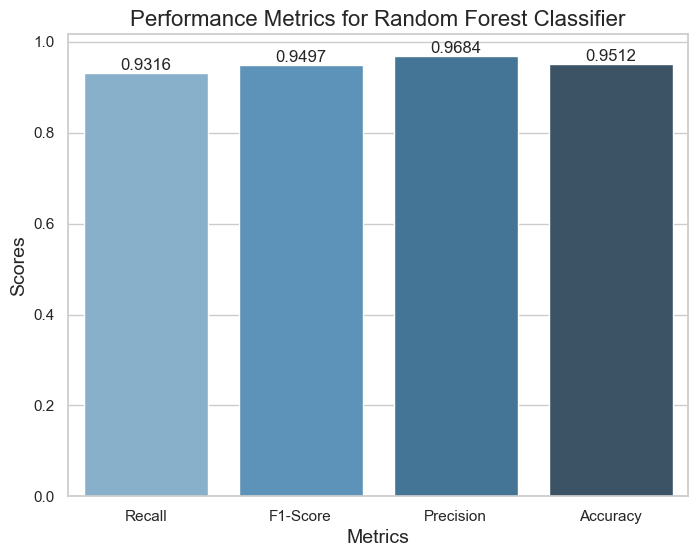

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the metric names and scores
metrics = ['Recall', 'F1-Score', 'Precision', 'Accuracy']
scores = [0.9316455696202531, 0.9496774193548386, 0.968421052631579, 0.951188986232791]

# Create a barplot with Seaborn
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=metrics, y=scores, palette="Blues_d")

# Adding annotations to the bar plot
for i, score in enumerate(scores):
    ax.text(i, score, round(score, 4), ha="center", va="bottom", fontsize=12)

# Setting labels and title
plt.title('Performance Metrics for Random Forest Classifier', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.show()


1/1 [==============================] - 0s 128ms/step
The Prediction is : Without_Ships
Actual Label:  With_Ships


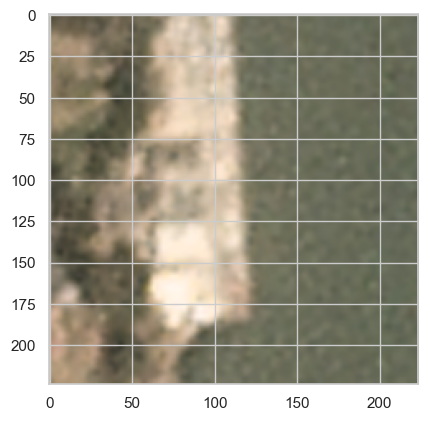

In [43]:
n = np.random.randint(0,X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img,axis=0)
input_img_feature = vgg_Model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0],-1)
predictionRF = rf.predict(input_img_feature)[0]
print("The Prediction is :",predictionRF)
print("Actual Label: ",y_test[n])

## ID3 ALGORITHM

In [46]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(featuresTrain,y_train)

DecisionTreeClassifier()

In [47]:
y_pred_dt = dt.predict(featuresTest)

In [48]:
from sklearn.metrics import accuracy_score
acc_dt = accuracy_score(y_test,y_pred_dt)
pre_dt = accuracy_score()

In [53]:
print(classification_report(y_test,y_pred_dt))
cm = classification_report(y_test,y_pred_dt)

               precision    recall  f1-score   support

   With_Ships       0.91      0.93      0.92       395
Without_Ships       0.93      0.91      0.92       404

     accuracy                           0.92       799
    macro avg       0.92      0.92      0.92       799
 weighted avg       0.92      0.92      0.92       799



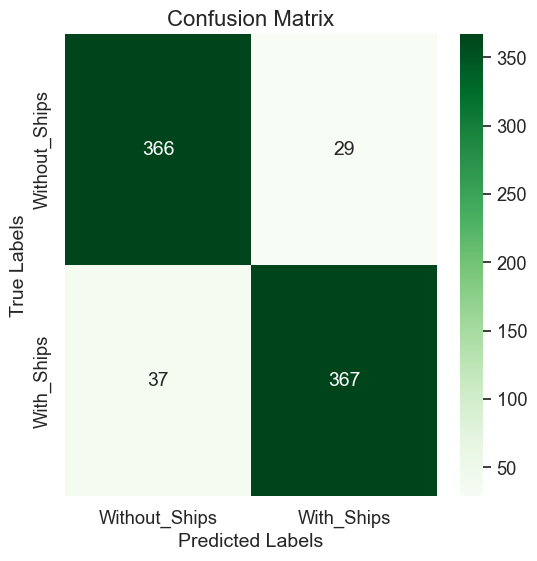

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming cm is the classification report you mentioned


# Extracting the true labels and the predicted labels
y_true = y_test  # Ensure y_test is in the appropriate format
y_pred = predictionRF  # Ensure predictionRF is in the appropriate format

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred_dt)

# Plotting the confusion matrix as a heatmap with a color bar
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=True, annot_kws={"size": 14},
            xticklabels=['Without_Ships', 'With_Ships'], yticklabels=['Without_Ships', 'With_Ships'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



In [56]:
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn import metrics

y_true_numeric = [1 if label == 'With_Ships' else 0 for label in y_test]
y_pred_numeric = [1 if label == 'With_Ships' else 0 for label in y_pred_dt]

print("Recall Score: ",recall_score(y_true_numeric,y_pred_numeric))
print("F1-Score: ",f1_score(y_true_numeric,y_pred_numeric))
print("Precision Score: ",precision_score(y_true_numeric,y_pred_numeric))
print("Accuracy = ",metrics.accuracy_score(y_true_numeric, y_pred_numeric))

Recall Score:  0.9265822784810127
F1-Score:  0.9172932330827068
Precision Score:  0.9081885856079405
Accuracy =  0.9173967459324155


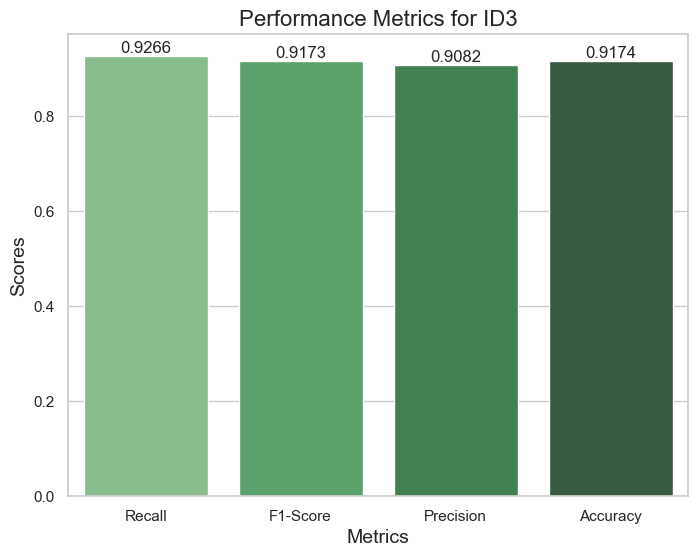

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the metric names and scores
metrics = ['Recall', 'F1-Score', 'Precision', 'Accuracy']
scores = [0.9265822784810127, 0.9172932330827068, 0.9081885856079405, 0.9173967459324155]

# Create a barplot with Seaborn using a green color palette
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=metrics, y=scores, palette=sns.color_palette("Greens_d", len(metrics)))

# Adding annotations to the bar plot
for i, score in enumerate(scores):
    ax.text(i, score, round(score, 4), ha="center", va="bottom", fontsize=12)

# Setting labels and title
plt.title('Performance Metrics for ID3', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.show()


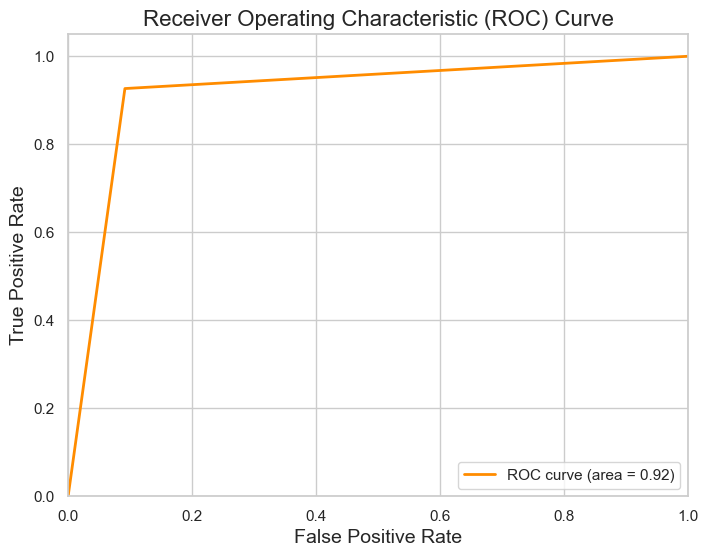

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the data is stored in y_true and y_pred variables
# Convert the string labels to numerical format as shown in the previous example

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_true_numeric, y_pred_numeric)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()


1/1 [==============================] - 0s 238ms/step
The Prediction is : With_Ships
Actual Label:  With_Ships


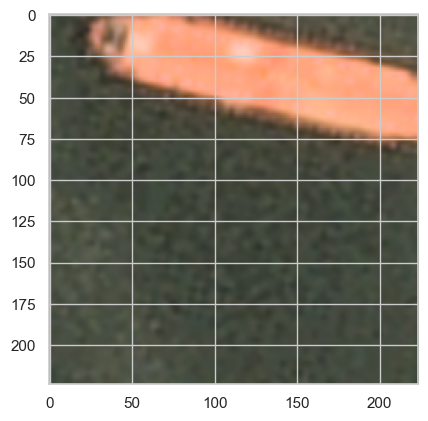

In [62]:
n = np.random.randint(0,X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img,axis=0)
input_img_feature = vgg_Model.predict(input_img)
input_img_feature = input_img_feature.reshape(input_img_feature.shape[0],-1)
y_pred_dt_tests = dt.predict(input_img_feature)[0]
print("The Prediction is :",y_pred_dt_tests)
print("Actual Label: ",y_test[n])

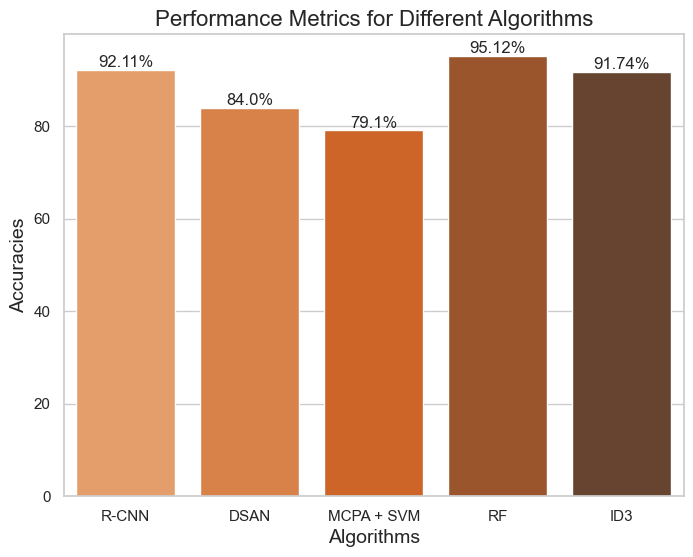

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

algorithms = ["R-CNN", "DSAN", "MCPA + SVM", "RF", "ID3"]
accuracies = [92.11, 84.0, 79.10, 95.12, 91.74]

# Create a barplot with Seaborn using an orange color palette
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=algorithms, y=accuracies, palette=sns.color_palette("Oranges_d", len(algorithms)))

# Adding annotations to the bar plot
for i, accuracy in enumerate(accuracies):
    ax.text(i, accuracy, f'{accuracy}%', ha="center", va="bottom", fontsize=12)

# Setting labels and title
plt.title('Performance Metrics for Different Algorithms', fontsize=16)
plt.xlabel('Algorithms', fontsize=14)
plt.ylabel('Accuracies', fontsize=14)
plt.show()
